# Проект e-commerce: вариант 1

### Задачи:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.(15 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. (23 балла)

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from datetime import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import requests
from urllib.parse import urlencode

sns.set(rc={'figure.figsize':(20, 12)}, style="whitegrid")
%matplotlib inline

## Описание данных:

#### uniq_id_df - таблица с уникальными идентификаторами пользователей

- `customer_id` — позаказный идентификатор пользователя

- `customer_unique_id` —  уникальный идентификатор пользователя  (аналог номера паспорта)

- `customer_zip_code_prefix` —  почтовый индекс пользователя

- `customer_city` —  город доставки пользователя

- `customer_state` —  штат доставки пользователя

#### order_df - таблица заказов

- `order_id` —  уникальный идентификатор заказа (номер чека)

- `customer_id` —  позаказный идентификатор пользователя

- `order_status` —  статус заказа

- `order_purchase_timestamp` —  время создания заказа

- `order_approved_at` —  время подтверждения оплаты заказа

- `order_delivered_carrier_date` —  время передачи заказа в логистическую службу

- `order_delivered_customer_date` —  время доставки заказа

- `order_estimated_delivery_date` —  обещанная дата доставки

##### Уникальные статусы заказов в таблице order_df:

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

#### products_df - товарные позиции, входящие в заказы

- `order_id` —  уникальный идентификатор заказа (номер чека)

- `order_item_id` —  идентификатор товара внутри одного заказа

- `product_id` —  ид товара (аналог штрихкода)

- `seller_id` — ид производителя товара

- `shipping_limit_date` —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- `price` —  цена за единицу товара

- `freight_value` —  вес товара

## Загружаем данные:

In [7]:
#Создадим переменные с ссылками на данные
url_uniq_id_df  = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
url_order_df    = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
url_products_df = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [8]:
#С помощью функции получим загрузочную ссылку
def url_download_ya_disk(public_key):
    base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    final_url    = base_url + urlencode(dict(public_key=public_key)) 
    response     = requests.get(final_url) 
    download_url = response.json()['href']

    return download_url

In [9]:
uniq_id_df  = pd.read_csv(url_download_ya_disk(url_uniq_id_df))
order_df    = pd.read_csv(url_download_ya_disk(url_order_df))
products_df = pd.read_csv(url_download_ya_disk(url_products_df))

In [5]:
uniq_id_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
uniq_id_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
order_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [8]:
order_df['order_purchase_timestamp']      = pd.to_datetime(order_df.order_purchase_timestamp)
order_df['order_approved_at']             = pd.to_datetime(order_df.order_approved_at)
order_df['order_delivered_carrier_date']  = pd.to_datetime(order_df.order_delivered_carrier_date)
order_df['order_delivered_customer_date'] = pd.to_datetime(order_df.order_delivered_customer_date)
order_df['order_estimated_delivery_date'] = pd.to_datetime(order_df.order_estimated_delivery_date)

In [9]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [10]:
products_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Чтобы ответить на данный вопрос, необходимо определить, что такое покупка.

В первую очередь, покупкой считается та операция, которая уже оплачена и передана покупателю.
То есть, оставим только те статусы заказов, которые подходят под это условие (**delivered** —  доставлен пользователю).

In [12]:
order_df.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [13]:
delivered_order_df = order_df.query("order_status not in ['invoiced', 'shipped', 'processing', 'unavailable', 'canceled', 'created', 'approved']")

In [14]:
delivered_order_df.order_status.unique()

array(['delivered'], dtype=object)

In [15]:
delivered_order_df.order_status.value_counts()

delivered    96478
Name: order_status, dtype: int64

Чтобы определить пользователя с единственной покупкой, необходимо определить уникальный `customer_id` — позаказный идентификатор пользователя, для этого объединим две таблицы с информацией по пользователю и заказу.

In [16]:
uniq_customers = uniq_id_df[['customer_id', 'customer_unique_id']]
uniq_customers

,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066
...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e


In [17]:
orders_customers = pd.merge(delivered_order_df, uniq_customers, how='left')
orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


In [18]:
df_orders_customers = orders_customers.groupby('customer_unique_id', as_index=False).agg({'order_id':'count'})
df_orders_customers

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1
93354,fffea47cd6d3cc0a88bd621562a9d061,1
93355,ffff371b4d645b6ecea244b27531430a,1
93356,ffff5962728ec6157033ef9805bacc48,1


In [19]:
df_orders_customers.order_id.unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 15])

In [20]:
customer_with_uniq_product = df_orders_customers.query("order_id == 1")
customer_with_uniq_product.shape[0]

90557

90557 пользователей, которые совершили покупку только один раз.

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Заказы, имеющие нижеперечисленные статусы, являются доставленными (успешными), либо относятся к этапам приёма товара (в процессе передачи заказа потребителю):
- created — создан
- approved — подтверждён
- invoiced — выставлен счёт
- processing — в процессе сборки заказа
- shipped — отгружен со склада
- delivered — доставлен пользователю

Заказы, которые не были доставлены пользователю (неуспешная операция), имеют статусы **unavailable** (недоступен) или **canceled** (отменён).

In [21]:
not_delivered_order = order_df.query("order_status not in ['invoiced', 'shipped', 'processing', 'created', 'approved', 'delivered']")

In [22]:
not_delivered_order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05


In [23]:
status_order = not_delivered_order.groupby('order_status', as_index=False)\
                                  .agg({'order_id':'count'})\
                                  .rename(columns={'order_id':'order_count'})
status_order

,order_status,order_count
0,canceled,625
1,unavailable,609


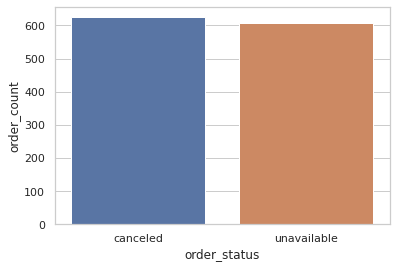

In [24]:
#Соотношение статусов заказов с неуспешными операциями
ax = sns.barplot(x='order_status', y='order_count', data = status_order)

In [25]:
not_delivered_order['order_estimated_delivery_month'] = pd.to_datetime(not_delivered_order['order_estimated_delivery_date'], errors='coerce').dt.strftime('%Y-%m')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
order_status_by_date = not_delivered_order.groupby(['order_estimated_delivery_month', 'order_status'], as_index=False)\
                                          .agg({'order_id':'count'})
order_status_by_date.head()

,order_estimated_delivery_month,order_status,order_id
0,2016-09,canceled,1
1,2016-10,canceled,3
2,2016-11,canceled,14
3,2016-11,unavailable,5
4,2016-12,canceled,8


In [27]:
order_by_date = order_status_by_date.groupby('order_status', as_index=False)\
                                    .agg({'order_id':'mean'}).round(2)\
                                    .rename(columns={'order_id':'order_mean'})
order_by_date

,order_status,order_mean
0,canceled,24.04
1,unavailable,29.00


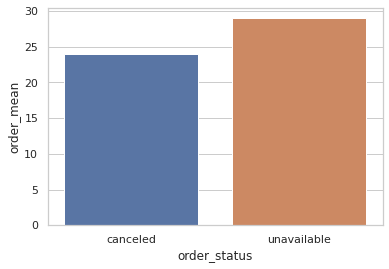

In [28]:
#Среднее месячное значение заказов по статусам/причинам, которые не доставляются.
ax = sns.barplot(x='order_status', y='order_mean', data = order_by_date)

Исходя из полученных результатов, можно заметить, что наиболее частой причиной отсутствия продажи товара в среднем в месяц является его **недоступность**, то есть дефицит продукта, либо иные причины, связанные с поломкой сайта для заказа товара. 

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Для дальнейшего анализа необходимо объединить таблицы заказов и товарных позиций.

In [29]:
order_products = pd.merge(order_df, products_df, how='left', on = 'order_id')
order_products.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [30]:
order_products['name_date'] = order_products['order_purchase_timestamp'].dt.day_name()

In [31]:
order_products.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,name_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [32]:
#Количество покупок каждого типа товара
count_purchase = order_products.groupby(['product_id', 'name_date'], as_index=False)\
              .agg({'price':'count'})
count_purchase

,product_id,name_date,price
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
61225,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
61226,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
61227,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [33]:
count_purchase.sort_values('price', ascending=False)

,product_id,name_date,price
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41041,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41046,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
...,...,...,...
24013,642369377615febc7fa89e4c8df5110e,Thursday,1
24018,642a40d4d73b4b2604968937de13634a,Sunday,1
24022,642e125cbc752b4eeb8faf442319c39f,Thursday,1
24025,64315bd8c0c47303179dd2e25b579d00,Saturday,1


In [34]:
most_popular_day = count_purchase.pivot(index='product_id', columns='name_date', values='price')\
              .idxmax(axis=1)\
              .reset_index()\
              .rename(columns={0:'name_day'})
most_popular_day

,product_id,name_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


In [35]:
#Проведём проверку на корректность отображения данных в таблице
most_popular_day.query("product_id == '422879e10f46682990de24d770e7f83d'")

,product_id,name_day
8613,422879e10f46682990de24d770e7f83d,Wednesday


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
Не стоит забывать, что внутри месяца может быть не целое количество недель. 
Например, в ноябре 2021 года 4,28 недели. 
И внутри метрики это нужно учесть.

Поскольку **покупка** - это операция, которая уже оплачена и передана покупателю. Будем рассматривать заказы со статусом `delivered`.

In [36]:
delivered_order_products = order_df.query("order_status not in ['invoiced', 'shipped', 'processing', 'unavailable', 'canceled', 'created', 'approved']")

In [37]:
delivered_purchase = pd.merge(uniq_id_df, delivered_order_products, how='left', on = 'customer_id')
delivered_purchase.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [38]:
delivered_purchase['order_purchase_month'] = pd.to_datetime(delivered_purchase['order_purchase_timestamp'], errors='coerce').dt.strftime('%Y-%m')
delivered_purchase.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [39]:
purchase_by_time = delivered_purchase.groupby(['order_purchase_timestamp', 'customer_unique_id'], as_index=False)\
                                     .agg({'order_id':'count'})\
                                     .rename(columns={'order_id':'order_count'})
purchase_by_time

,order_purchase_timestamp,customer_unique_id,order_count
0,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,1
1,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,1
2,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1
3,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1
4,2016-10-03 22:06:03,8d3a54507421dbd2ce0a1d58046826e0,1
...,...,...,...
96206,2018-08-29 12:25:59,7a22d14aa3c3599238509ddca4b93b01,1
96207,2018-08-29 14:18:23,5c58de6fb80e93396e2f35642666b693,1
96208,2018-08-29 14:18:28,7febafa06d9d8f232a900a2937f04338,1
96209,2018-08-29 14:52:00,b701bebbdf478f5500348f03aff62121,1


In [40]:
purchase_by_time['month_order'] = purchase_by_time.order_purchase_timestamp.dt.month
purchase_by_time['week_year'] = purchase_by_time.order_purchase_timestamp.dt.isocalendar().week
purchase_by_time['days_in_month'] = purchase_by_time.order_purchase_timestamp.dt.daysinmonth

In [41]:
purchase_by_time.head()

,order_purchase_timestamp,customer_unique_id,order_count,month_order,week_year,days_in_month
0,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,1,9,37,30
1,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,1,10,40,31
2,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1,10,40,31
3,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1,10,40,31
4,2016-10-03 22:06:03,8d3a54507421dbd2ce0a1d58046826e0,1,10,40,31


In [42]:
purchase_by_time['count_week'] = (purchase_by_time['days_in_month']/7).round(2)
purchase_by_time

,order_purchase_timestamp,customer_unique_id,order_count,month_order,week_year,days_in_month,count_week
0,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,1,9,37,30,4.29
1,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,1,10,40,31,4.43
2,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1,10,40,31,4.43
3,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1,10,40,31,4.43
4,2016-10-03 22:06:03,8d3a54507421dbd2ce0a1d58046826e0,1,10,40,31,4.43
...,...,...,...,...,...,...,...
96206,2018-08-29 12:25:59,7a22d14aa3c3599238509ddca4b93b01,1,8,35,31,4.43
96207,2018-08-29 14:18:23,5c58de6fb80e93396e2f35642666b693,1,8,35,31,4.43
96208,2018-08-29 14:18:28,7febafa06d9d8f232a900a2937f04338,1,8,35,31,4.43
96209,2018-08-29 14:52:00,b701bebbdf478f5500348f03aff62121,1,8,35,31,4.43


In [43]:
purchase_by_time['average_purchase'] = np.round(purchase_by_time['order_count']/purchase_by_time['count_week'], 4)
purchase_by_time

,order_purchase_timestamp,customer_unique_id,order_count,month_order,week_year,days_in_month,count_week,average_purchase
0,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,1,9,37,30,4.29,0.2331
1,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,1,10,40,31,4.43,0.2257
2,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1,10,40,31,4.43,0.2257
3,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1,10,40,31,4.43,0.2257
4,2016-10-03 22:06:03,8d3a54507421dbd2ce0a1d58046826e0,1,10,40,31,4.43,0.2257
...,...,...,...,...,...,...,...,...
96206,2018-08-29 12:25:59,7a22d14aa3c3599238509ddca4b93b01,1,8,35,31,4.43,0.2257
96207,2018-08-29 14:18:23,5c58de6fb80e93396e2f35642666b693,1,8,35,31,4.43,0.2257
96208,2018-08-29 14:18:28,7febafa06d9d8f232a900a2937f04338,1,8,35,31,4.43,0.2257
96209,2018-08-29 14:52:00,b701bebbdf478f5500348f03aff62121,1,8,35,31,4.43,0.2257


## 5. Используя pandas, проведи когортный анализ пользователей. 
В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Чтобы провести дальнейший анализ, создадим объёдинённый датафрейм из 2 таблиц, используя только необходимые столбцы.

В дальнейшем будем использовать данные пользователей, имеющих статус (`delivered` — доставлен пользователю), поскольку нас не интересуют промежуточные этапы передачи заказа покупателю, а также неуспешные операции пользователей (которые не имеют первой покупки товара, но с отменённым статусом), данные будут нерелевантны.

In [44]:
df_orders_customers = pd.merge(delivered_order_df, uniq_id_df, how='left', on = 'customer_id')
df_orders_customers = df_orders_customers[['customer_unique_id','order_id','order_purchase_timestamp']]
df_orders_customers.head()

,customer_unique_id,order_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [45]:
df_orders_customers['order_month'] = pd.to_datetime(df_orders_customers['order_purchase_timestamp'], errors='coerce').dt.strftime('%Y-%m')
df_orders_customers.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_month
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02


In [46]:
df_orders_customers.isnull().sum()

customer_unique_id          0
order_id                    0
order_purchase_timestamp    0
order_month                 0
dtype: int64

In [47]:
df_orders_customers.shape

(96478, 4)

Сформируем датафрейм, где вычислим дату первой покупки каждого покупателя.

In [48]:
first_orders = df_orders_customers.groupby('customer_unique_id')['order_month']\
                                                         .agg(order_purchase_timestamp = 'min')\
                                                         .rename(columns={'order_purchase_timestamp':'first_order'})
first_orders

,first_order
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
0000f46a3911fa3c0805444483337064,2017-03
0000f6ccb0745a6a4b88665a16c9f078,2017-10
0004aac84e0df4da2b147fca70cf8255,2017-11
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06
fffea47cd6d3cc0a88bd621562a9d061,2017-12
ffff371b4d645b6ecea244b27531430a,2017-02


In [49]:
#Присоединим полученную колонку к исходному датафрейму для дальнейшего анализа
first_orders_customers = df_orders_customers.merge(first_orders, how='inner', on='customer_unique_id')
first_orders_customers

,customer_unique_id,order_id,order_purchase_timestamp,order_month,first_order
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,69923a4e07ce446644394df37a710286,2017-09-04 11:26:38,2017-09,2017-09
2,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07,2018-07
3,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08,2018-08
4,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11,2017-11
...,...,...,...,...,...
96473,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,2017-03,2017-03
96474,da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,2018-02,2018-02
96475,737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,2017-08,2017-08
96476,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,2018-01,2018-01


In [50]:
first_orders_customers.isnull().sum()

customer_unique_id          0
order_id                    0
order_purchase_timestamp    0
order_month                 0
first_order                 0
dtype: int64

In [51]:
cohorts = first_orders_customers.groupby(['first_order', 'order_month'])\
                                .agg({'customer_unique_id' : pd.Series.nunique,
                                      'order_id':'count'})\
                                .rename(columns={'customer_unique_id':'count_customers',
                                                'order_id':'count_purchase'})
cohorts

count_customers  count_purchase
first_order order_month                                 
2016-09     2016-09                    1               1
2016-10     2016-10                  262             265
            2017-04                    1               1
            2017-07                    1               1
            2017-09                    1               1
...                                  ...             ...
2018-06     2018-07                   25              25
            2018-08                   16              16
2018-07     2018-07                 5949            6007
            2018-08                   31              31
2018-08     2018-08                 6144            6180

[219 rows x 2 columns]

In [52]:
#Функция для расчёта пертода когорты:
def cohort_period(df):
     df['Cohort_Period'] = np.arange(len(df)) + 1
     return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [53]:
cohorts

count_customers  count_purchase  Cohort_Period
first_order order_month                                                
2016-09     2016-09                    1               1              1
2016-10     2016-10                  262             265              1
            2017-04                    1               1              2
            2017-07                    1               1              3
            2017-09                    1               1              4
...                                  ...             ...            ...
2018-06     2018-07                   25              25              2
            2018-08                   16              16              3
2018-07     2018-07                 5949            6007              1
            2018-08                   31              31              2
2018-08     2018-08                 6144            6180              1

[219 rows x 3 columns]

Отобразим таблицу в расширенном варианте для отображения полной картины.

In [54]:
full_cohorts = cohorts.pivot_table(index='first_order', columns='Cohort_Period', values='count_purchase')
full_cohorts

Cohort_Period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
first_order,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,265.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,749.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1651.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0
2017-03,2541.0,12.0,9.0,12.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0
2017-04,2284.0,15.0,6.0,5.0,6.0,6.0,9.0,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,4.0,NaN
2017-05,3517.0,17.0,16.0,10.0,10.0,12.0,16.0,5.0,9.0,11.0,9.0,12.0,8.0,1.0,6.0,7.0,NaN,NaN
2017-06,3092.0,16.0,13.0,13.0,10.0,12.0,11.0,7.0,4.0,6.0,9.0,12.0,5.0,6.0,10.0,NaN,NaN,NaN


Рассчитаем retention

In [55]:
#Обозначим первый столбец, как коэффициент с 1 для последующего расчёта показателя.
coef = full_cohorts[1]
retention = full_cohorts.divide(coef, axis=0).round(4)
retention

Cohort_Period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
first_order,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,0.0038,0.0038,0.0038,0.0038,0.0038,0.0038,0.0075,0.0075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.0027,0.0027,0.0013,0.0040,0.0013,0.0040,0.0013,0.0013,0.0040,0.0013,0.0067,0.0040,0.0013,0.0013,0.0027,0.0040,0.0013
2017-02,1.0,0.0018,0.0030,0.0012,0.0042,0.0012,0.0024,0.0018,0.0012,0.0018,0.0012,0.0030,0.0012,0.0018,0.0012,0.0006,0.0006,0.0018
2017-03,1.0,0.0047,0.0035,0.0047,0.0035,0.0016,0.0016,0.0031,0.0031,0.0008,0.0035,0.0012,0.0020,0.0012,0.0016,0.0024,0.0008,0.0012
2017-04,1.0,0.0066,0.0026,0.0022,0.0026,0.0026,0.0039,0.0031,0.0031,0.0018,0.0026,0.0009,0.0004,0.0004,0.0009,0.0009,0.0018,NaN
2017-05,1.0,0.0048,0.0045,0.0028,0.0028,0.0034,0.0045,0.0014,0.0026,0.0031,0.0026,0.0034,0.0023,0.0003,0.0017,0.0020,NaN,NaN
2017-06,1.0,0.0052,0.0042,0.0042,0.0032,0.0039,0.0036,0.0023,0.0013,0.0019,0.0029,0.0039,0.0016,0.0019,0.0032,NaN,NaN,NaN


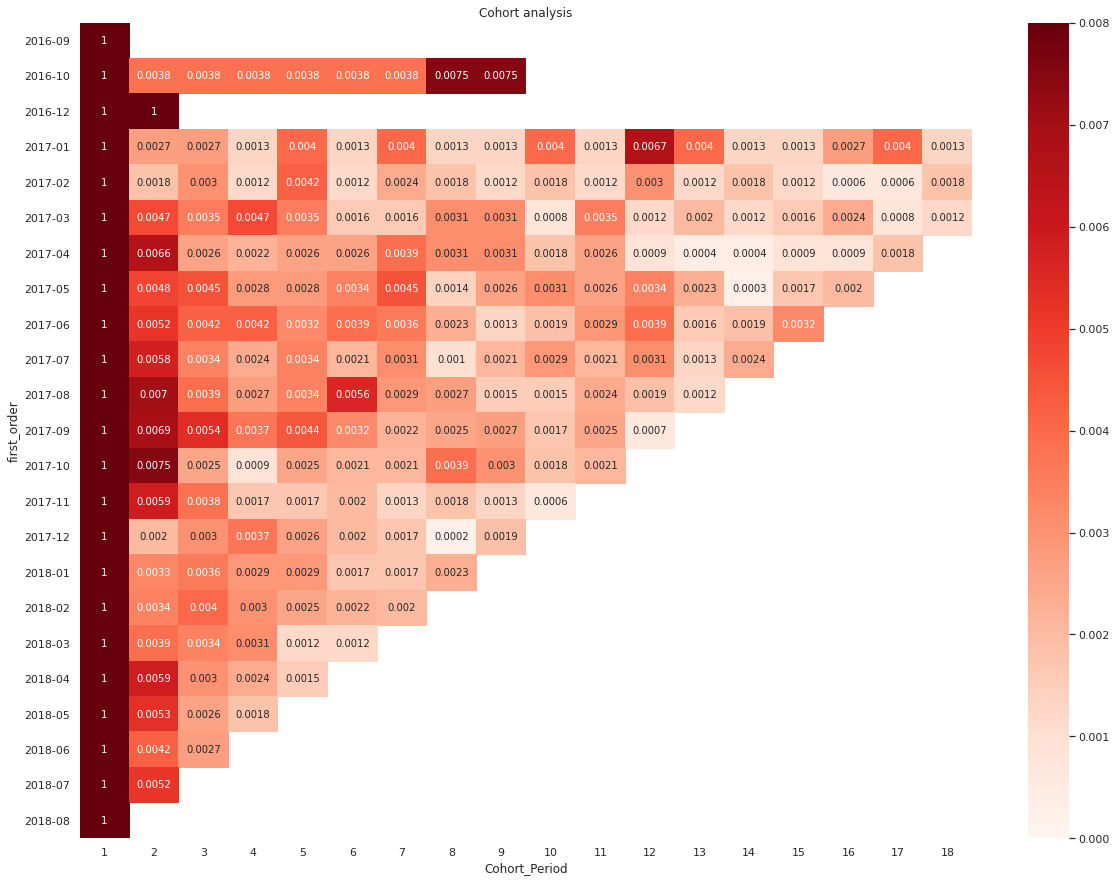

In [144]:
plt.figure(figsize=(20,15))
plt.title('Cohort analysis')
ax = sns.heatmap(retention, annot=True, cmap='Reds', vmin=0.0,vmax=0.008)
plt.show()

Исходя из графика, можем сделать вывод, что на 3 месяц (4 период в таблице, так как 1 - это период с базисным коэффициентом) самый большой показатель **0.0047** (0.47%) у кагорты `2017-03`.

## 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Для построения RFM-сегментации объединим 3 таблицы в 1 датафрейм. 
Аналогично, будем использовать датафрейм со статусами заказов `delivered`, что говорит о  совершении покупки покупателем.

In [210]:
df_segmentation = pd.merge(delivered_order_df, uniq_id_df, how='left', on = 'customer_id')
full_segmentation = pd.merge(df_segmentation, products_df, how='left', on = 'order_id')
full_segmentation.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [211]:
full_segmentation.order_status.unique()

array(['delivered'], dtype=object)

In [212]:
full_segmentation.shape

(110197, 18)

In [213]:
full_segmentation.isnull().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                15
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
order_item_id                     0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
dtype: int64

In [214]:
full_segmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 110196
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  object        
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110195 non-null  datetime64[ns]
 6   order_delivered_customer_date  110189 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 8   customer_unique_id             110197 non-null  object        
 9   customer_zip_code_prefix       110197 non-null  int64         
 10  customer_city                  110197 non-null  object        
 11  

Отобразим в датафрейме необходимые столбцы для RFM-анализа, к ним относятся `уникальные id пользоваталей`, `время покупки конкретного пользователя`, `заказ покупателя`, `сумма покупки`.

In [215]:
full_segmentation = full_segmentation[['order_id', 'customer_unique_id', 'order_purchase_timestamp', 'price']]
full_segmentation

,order_id,customer_unique_id,order_purchase_timestamp,price
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,19.90
...,...,...,...,...
110192,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,174.90
110193,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,205.99
110194,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,179.99
110195,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,179.99


Установим отчётную дату `today` и включительно 1 день после последней покупки, которая считает дату не текущую дату, а от самой последней покупки.

In [216]:
today = full_segmentation['order_purchase_timestamp'].max() + timedelta(days=1)

Рассчитаем метрики: 
**R** - время от последней покупки пользователя до текущей даты, **F** - суммарное количество покупок у пользователя за всё время, **M** - сумма покупок за всё время.

In [217]:
Recency = full_segmentation.groupby('customer_unique_id')\
                           .agg({'order_purchase_timestamp' : lambda x: (today - x.max()).days})\
                           .reset_index()\
                           .rename(columns={'order_purchase_timestamp': 'Recency'})
Recency

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115
2,0000f46a3911fa3c0805444483337064,537
3,0000f6ccb0745a6a4b88665a16c9f078,321
4,0004aac84e0df4da2b147fca70cf8255,288
...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,447
93354,fffea47cd6d3cc0a88bd621562a9d061,262
93355,ffff371b4d645b6ecea244b27531430a,568
93356,ffff5962728ec6157033ef9805bacc48,119


In [218]:
Frequency = full_segmentation.groupby('customer_unique_id')\
                           .agg({'order_purchase_timestamp' : 'count'})\
                           .reset_index()\
                           .rename(columns={'order_purchase_timestamp': 'Frequency'})
Frequency

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,2
93354,fffea47cd6d3cc0a88bd621562a9d061,1
93355,ffff371b4d645b6ecea244b27531430a,1
93356,ffff5962728ec6157033ef9805bacc48,1


In [219]:
Monetary = full_segmentation.groupby('customer_unique_id')\
                           .agg({'price' : 'sum'})\
                           .reset_index()\
                           .rename(columns={'price': 'Monetary'})
Monetary

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00
...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
93354,fffea47cd6d3cc0a88bd621562a9d061,64.89
93355,ffff371b4d645b6ecea244b27531430a,89.90
93356,ffff5962728ec6157033ef9805bacc48,115.00


Объединяем полученнные метрики в датафрейм.

In [220]:
RFM = pd.merge(Recency, Frequency, on = 'customer_unique_id')
RFM_metrics = pd.merge(RFM, Monetary, on = 'customer_unique_id')
RFM_metrics

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00
93354,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93355,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93356,ffff5962728ec6157033ef9805bacc48,119,1,115.00


Рассчитаем баллы R, F и M.

Рассмотрим на графиках метрики, чтобы определить тенденцию изменений показателей и выделим сегменты пользователей.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


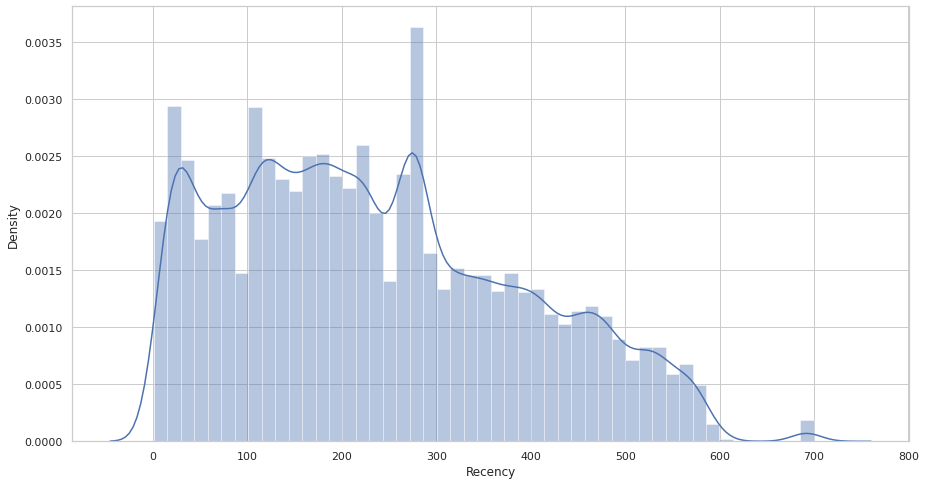

In [221]:
plt.figure(figsize=(15,8))
sns.distplot(RFM_metrics.Recency, kde=True)

Визуально можем разделить на 3 сегмента с использованием квантиелей, содержащих 33,3% покупателей.

Использование квинтилей является более гибким способом, поскольку диапазоны будут адаптироваться к данным и будут работать в разных отраслях или в случае каких-либо изменений в ожидаемом поведении клиентов.

In [222]:
RFM_metrics.Recency.describe()

count    93358.000000
mean       237.941773
std        152.591453
min          1.000000
25%        114.000000
50%        219.000000
75%        346.000000
max        714.000000
Name: Recency, dtype: float64

In [223]:
print(RFM_metrics.Recency.quantile(0.33))
print(RFM_metrics.Recency.quantile(0.66))

147.0
286.0


Присвоим ранги от 1 до 3. Чем меньше значение Recency, тем лучше показатель. 

- 1 - больше 290 дней, чуть больше, чем 0,66 перцентиль (исходя из графика, видим, что есть большой выброс около 290 дней, возьмём данное значение в эту кагорту)
- 2 - интервал между 0,33 и 0,66 перцентилем
- 3 - меньше 0,33 перцентиля

In [224]:
def r_score(x):
    if x <= RFM_metrics.Recency.quantile(0.33):
        return 3
    elif x > 290:
        return 1
    else:
        return 2

RFM_metrics['r_score'] = RFM_metrics.Recency.apply(r_score)

In [225]:
RFM_metrics.head()

,customer_unique_id,Recency,Frequency,Monetary,r_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


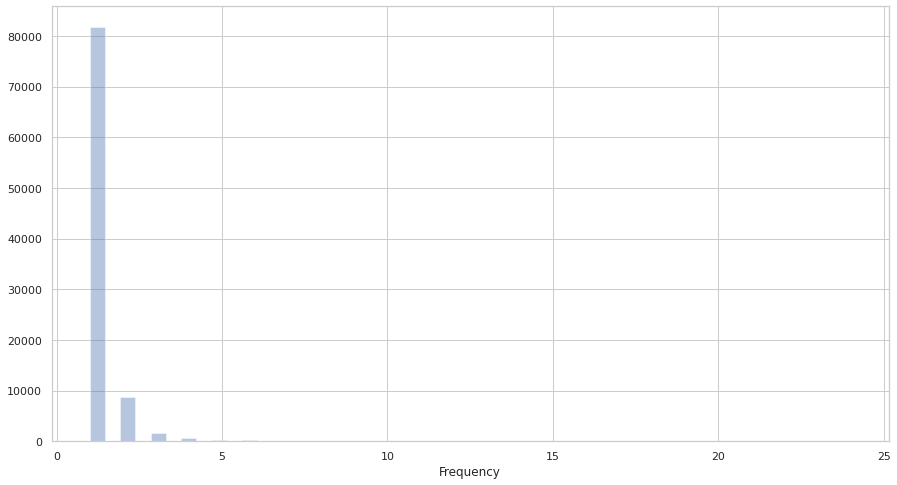

In [226]:
plt.figure(figsize=(15,8))
sns.distplot(RFM_metrics.Frequency, kde=False)

Распределение суммарного количества покупок пользователей имеет узкий разброс, поэтому поделим на группы:

- 1 - 1 заказ
- 2 - 2 заказа
- 3 - 3 и более заказов

In [227]:
def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    else:
        return 3

RFM_metrics['f_score'] = RFM_metrics.Frequency.apply(f_score)

In [228]:
RFM_metrics.head()

,customer_unique_id,Recency,Frequency,Monetary,r_score,f_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


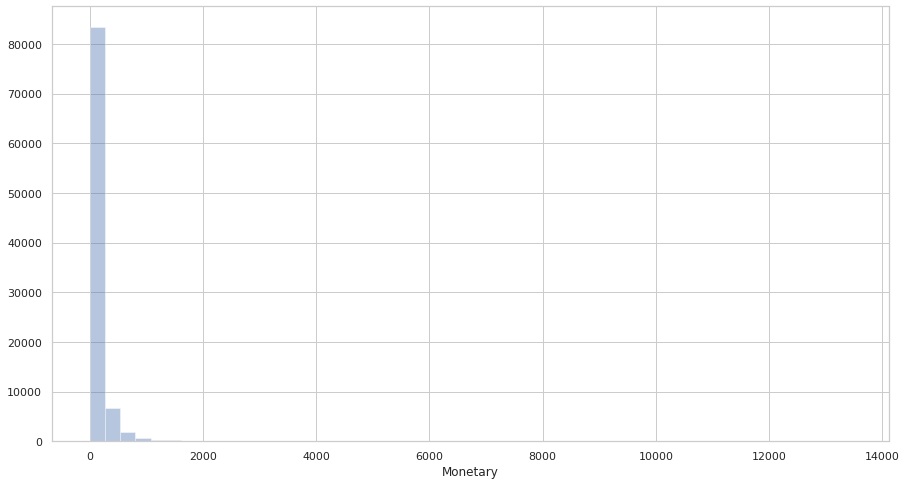

In [229]:
plt.figure(figsize=(15,8))
sns.distplot(RFM_metrics.Monetary, kde=False)

Распределение значений суммы покупок пользователей также имеет неширокий разброс значений, определим примерные границы разброса:

In [230]:
RFM_metrics.Monetary.describe()

count    93358.000000
mean       141.621480
std        215.694014
min          0.850000
25%         47.650000
50%         89.730000
75%        154.737500
max      13440.000000
Name: Monetary, dtype: float64

Выделим следующие кагорты, исходя из границ 25-го и 75-го перцентиля:

- 1 - до 100 д.е
- 2 - до 500 д.е
- 3 - от 500 и более д.е

In [231]:
def m_score(x):
    if x <= 100:
        return 1
    elif x <= 500:
        return 2
    else:
        return 3

RFM_metrics['m_score'] = RFM_metrics.Monetary.apply(m_score)

In [232]:
#Получим сегменты клиентов из оценки RFM
RFM_metrics

,customer_unique_id,Recency,Frequency,Monetary,r_score,f_score,m_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,2
...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00,1,2,3
93354,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,2,1,1
93355,ffff371b4d645b6ecea244b27531430a,568,1,89.90,1,1,1
93356,ffff5962728ec6157033ef9805bacc48,119,1,115.00,3,1,2


In [233]:
RFM_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93358 non-null  object 
 1   Recency             93358 non-null  int64  
 2   Frequency           93358 non-null  int64  
 3   Monetary            93358 non-null  float64
 4   r_score             93358 non-null  int64  
 5   f_score             93358 non-null  int64  
 6   m_score             93358 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 5.7+ MB


In [234]:
RFM_metrics['RFM'] = RFM_metrics.r_score.astype(str)+RFM_metrics.f_score.astype(str)+RFM_metrics.m_score.astype(str)
RFM_metrics

,customer_unique_id,Recency,Frequency,Monetary,r_score,f_score,m_score,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,2,212
...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00,1,2,3,123
93354,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,2,1,1,211
93355,ffff371b4d645b6ecea244b27531430a,568,1,89.90,1,1,1,111
93356,ffff5962728ec6157033ef9805bacc48,119,1,115.00,3,1,2,312


In [235]:
RFM_metrics_df = RFM_metrics.groupby('RFM', as_index=False)\
                            .agg({'customer_unique_id':'count'})
RFM_metrics_df.head()

,RFM,customer_unique_id
0,111,16922
1,112,9301
2,113,985
3,121,1147
4,122,1609


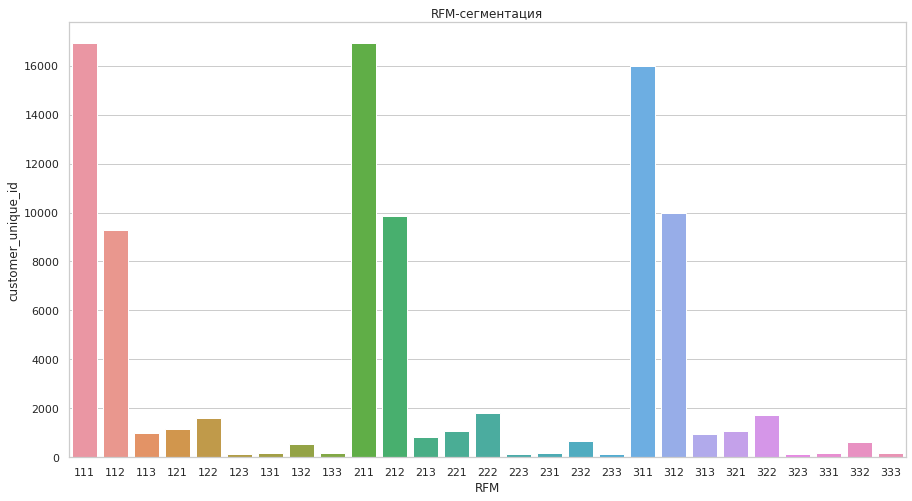

In [236]:
plt.figure(figsize=(15,8))
plt.title('RFM-сегментация')
sns.barplot(data = RFM_metrics_df, x='RFM', y='customer_unique_id')

In [244]:
RFM_metrics_df['count_perc'] = np.round(RFM_metrics_df.customer_unique_id*100 / RFM_metrics_df.customer_unique_id.sum(),2).astype(str)+'%'

In [248]:
RFM_metrics_df.sort_values('customer_unique_id', ascending=False)

,RFM,customer_unique_id,count_perc
0,111,16922,18.13%
9,211,16909,18.11%
18,311,15989,17.13%
19,312,9972,10.68%
10,212,9868,10.57%
1,112,9301,9.96%
13,222,1802,1.93%
22,322,1739,1.86%
4,122,1609,1.72%
3,121,1147,1.23%


Исходя из представленного распределения, можем сделать вывод, что наибольшим кластером покупателей являются `111`, `211`, `311`. 

**По временному периоду покупок**:
- 1 - старые клиенты (от 9 мес.)
- 2 - средней давности (от 3 мес. до 9 мес.)
- 3 - недавние клиенты (до 3 мес.)

**По частоте покупок**:
- 1 — покупает редко (по 1 покупке)
- 2 — покупает нечасто (по 2 покупки)
- 3 — покупает часто (3 и более)

**По сумме покупок**:
- 1 — маленькая сумма (до 100 д.е.)
- 2 — средняя сумма (от 100 до 500 д.е.)
- 3 — большая сумма (от 500 д.е.)

Составим портрет потребителя: клиент в каждом из трёх временных категорий совершал единичную покупку и на небольшую сумму (в среднем на 89,73 д.е.). 